In [26]:
#! /usr/bin/env python

from preprocessing import BatchGenerator
from preprocessing import parse_annotation, parse_annotation_csv
from frontend import YOLO
from datetime import datetime
import numpy as np
import tensorflow as tf
import shutil
import json
import keras
import argparse
import os

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)


config_path = 'config.json'

keras.backend.tensorflow_backend.set_session(get_session())

with open(config_path) as config_buffer:    
    config = json.loads(config_buffer.read())

###############################
#   Parse the annotations 
###############################

if config['parser_annotation_type'] == 'xml':
    # parse annotations of the training set
    train_imgs, train_labels = parse_annotation(config['train']['train_annot_folder'], 
                                                config['train']['train_image_folder'], 
                                                config['model']['labels'])

    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(config['valid']['valid_annot_folder']):
        valid_imgs, valid_labels = parse_annotation(config['valid']['valid_annot_folder'], 
                                                    config['valid']['valid_image_folder'], 
                                                    config['model']['labels'])
        split = False
    else:
        split = True
elif config['parser_annotation_type'] == 'csv':
    # parse annotations of the training set
    train_imgs, train_labels = parse_annotation_csv(config['train']['train_csv_file'],
                                                    config['model']['labels'],
                                                    config['train']['train_csv_base_path'])

    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(config['valid']['valid_csv_file']):
        valid_imgs, valid_labels = parse_annotation_csv(config['valid']['valid_csv_file'],
                                                    config['model']['labels'],
                                                    config['valid']['valid_csv_base_path'])
        split = False
    else:
        split = True
else:
    raise ValueError("'parser_annotations_type' must be 'xml' or 'csv' not {}.".format(config['parser_annotations_type']))


if split:
    train_valid_split = int(0.8*len(train_imgs))
    np.random.shuffle(train_imgs)

    valid_imgs = train_imgs[train_valid_split:]
    train_imgs = train_imgs[:train_valid_split]

if len(config['model']['labels']) > 0:
    overlap_labels = set(config['model']['labels']).intersection(set(train_labels.keys()))

    print('Seen labels:\t', train_labels)
    print('Given labels:\t', config['model']['labels'])
    print('Overlap labels:\t', overlap_labels)           

    if len(overlap_labels) < len(config['model']['labels']):
        print('Some labels have no annotations! Please revise the list of labels in the config.json file!')
        exit(1)
else:
    print('No labels are provided. Train on all seen labels.')
    print('Seen labels:\t', train_labels)
    config['model']['labels'] = train_labels.keys()
    with open("labels.json", 'w') as outfile:
        json.dump({"labels" : list(train_labels.keys())},outfile)
        

###############################
#   Construct the model 
###############################

yolo = YOLO(backend             = config['model']['backend'],
            input_size          = (config['model']['input_size_h'], config['model']['input_size_w']), 
            labels              = config['model']['labels'], 
            max_box_per_image   = config['model']['max_box_per_image'],
            anchors             = config['model']['anchors'],
            gray_mode           = config['model']['gray_mode'])


generator_config = {
    'IMAGE_H'         : yolo.input_size[0], 
    'IMAGE_W'         : yolo.input_size[1],
    'IMAGE_C'         : yolo.input_size[2],
    'GRID_H'          : yolo.grid_h,  
    'GRID_W'          : yolo.grid_w,
    'BOX'             : yolo.nb_box,
    'LABELS'          : yolo.labels,
    'CLASS'           : len(yolo.labels),
    'ANCHORS'         : yolo.anchors,
    'BATCH_SIZE'      : config['train']['batch_size'],
    'TRUE_BOX_BUFFER' : yolo.max_box_per_image,
}    


train_generator = BatchGenerator(train_imgs, 
                                 generator_config, 
                                 norm=None)


No labels are provided. Train on all seen labels.
Seen labels:	 {'chair': 1432, 'car': 1644, 'horse': 406, 'person': 5447, 'bicycle': 418, 'cat': 389, 'dog': 538, 'head': 439, 'foot': 434, 'hand': 681, 'train': 328, 'aeroplane': 331, 'diningtable': 310, 'tvmonitor': 367, 'bird': 599, 'bottle': 634, 'motorbike': 390, 'pottedplant': 625, 'boat': 398, 'sofa': 425, 'sheep': 353, 'cow': 356, 'bus': 272}
(13, 13)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
Tiny_YOLO_backend (Model)       (None, 13, 13, 1024) 15739760    input_5[0][0]                    
______________________________________________________________________________________________

In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

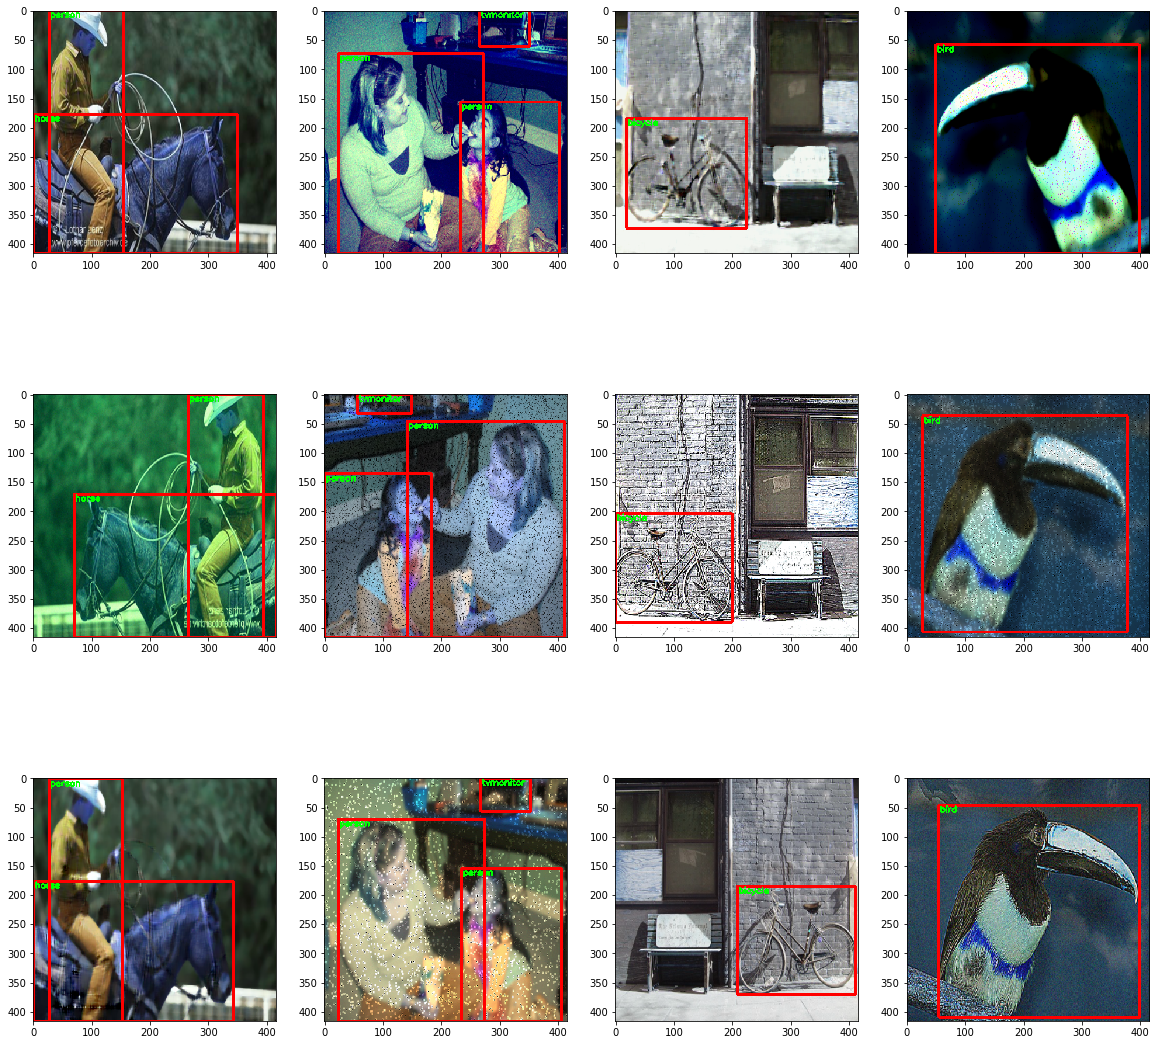

In [48]:
def im_show(cv_img):
    cv_img = cv_img.astype(np.uint8)
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
plt.figure(figsize=(20,20))
    
for r in range(3):
    [img_batch, b_batch], gt_batch = train_generator[0]

    for i, image in enumerate(img_batch):
        idx = (r * len(img_batch)) + i + 1

        plt.subplot(3, len(img_batch), idx)
        im_show(image)
